In [1]:
import tensorflow as tf
import os
import sys

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import os
import sys
import copy
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import concatenate, UpSampling2D

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import MeanIoU
import math
import cv2


from PIL import Image



In [2]:
mrcnnpath = "/home/ragou/repo/github/mask/Mask_RCNN"
sys.path.append(mrcnnpath)

In [3]:
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.config import Config
 

# 1 image = 1 PU

CONVERSION : 

# Position 67 pour une protéine ) 130 rés 

130 --> 67

256 --> x

x_scaled = 67 * 256/130 = 131

x_scaled = pos * (SIZE/shape)



# Reverse 

256 --> 131
130 --> x

x_true = 130 * (131/256)

x_true = pos * (shape / SIZE)


In [376]:

 # class that defines and loads the kangaroo dataset
class PUDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, images_dir, prot_name):
        self.IMG_SIZE = 512
        # define one class
        self.add_class("dataset", 1, "PU")
        # define data locations
        # find all images
        for image_id,prot in enumerate(prot_name):
            prot = prot[0]
            img_path = images_dir + prot + "/file_proba_contact.mat"
            annot_path = images_dir + prot + "/Peeling/Peeling.log"
            self.add_image('dataset', image_id=image_id, path=img_path, annot = annot_path)

    def log_to_res(self, logfile):
        all_coords = []
        with open(logfile) as filin:
            for line in filin:
                if not line.startswith("#"):
                    clean_coord = line.strip().split()[5:]
                    xy = [[int(clean_coord[x]),int(clean_coord[x+1])] for x in range(0,len(clean_coord)-1,2)]
                    all_coords.append(xy)
        return all_coords[-1]
    
    
    def get_PU(self, image_id):
        info = self.image_info[image_id]
        path = info['annot']
        PU = self.log_to_res(path)
        PU_list = []
        labels = []
        shape_image = sorted(PU)[-1][-1]
        for couple in PU:
            PU_list = []
            for res in couple:
                PU_list.append(int(res * self.IMG_SIZE /shape_image ))
            labels.append(PU_list)
        return labels
        
        
    def load_image(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        
        image = np.loadtxt(path) * 255
        image = cv2.cvtColor(np.array(image).astype(np.uint8), cv2.COLOR_RGB2BGR)
        image = resize(image, (self.IMG_SIZE, self.IMG_SIZE), mode='constant', preserve_range=True).astype(np.uint8)

        return image
    
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        path = info['annot']
        # load XML
        PU_list = self.get_PU(image_id)
        # create one array for all masks, each on a different channel
        masks = np.zeros([self.IMG_SIZE, self.IMG_SIZE, len(PU_list)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(PU_list)):
            box = PU_list[i]
            x, y = box[0], box[1]
            masks[x:y, x:y, i] = 1
            class_ids.append(1)
        return masks, np.asarray(class_ids, dtype='int32')
    

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [377]:

# define a configuration for the model
class PUConfig(Config):
    # define the name of the configuration
    NAME = "SWORD_PU_cfg"
    # number of classes (background + PU)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131
    # # MAX_GT_INSTANCES = 50
    # # POST_NMS_ROIS_INFERENCE = 500
    # # POST_NMS_ROIS_TRAINING = 1000
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    TRAIN_ROIS_PER_IMAGE = 200
    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1


    IMAGES_PER_GPU = 1

    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    BACKBONE = "resnet50"

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # IMAGE_MIN_SCALE = 0
 
    IMAGE_CHANNEL_COUNT = 3
    LEARNING_RATE = 0.0001
    

In [378]:
images_dir = "../sword/SWORD/PDBs_Clean/"
prot_name = next(os.walk(images_dir))[1]

In [379]:
prot_train.values.tolist()

[['1COBA'],
 ['1STFI'],
 ['3HHRB'],
 ['451CA'],
 ['1LTSA'],
 ['1AMPA'],
 ['1RPRA'],
 ['2CUTA'],
 ['1RISA'],
 ['1SNCA'],
 ['1PSPA'],
 ['1LBAA'],
 ['2PIAA'],
 ['2LHBA'],
 ['1EPAA'],
 ['8I1BA'],
 ['1HCDA'],
 ['1LABA'],
 ['1OVBA'],
 ['1RIBA'],
 ['4BLMA'],
 ['2BNHA'],
 ['1RNDA'],
 ['4HTCI'],
 ['1FC2D'],
 ['1HRHA'],
 ['1HCNB'],
 ['1HPLA'],
 ['2MTAC'],
 ['1XIMA'],
 ['1FBAA'],
 ['1NARA'],
 ['1GLAF'],
 ['2NCKR'],
 ['1PIIA'],
 ['1CIDA'],
 ['1BVHA'],
 ['1CC5A'],
 ['2RN2A'],
 ['2MEV1'],
 ['1HSQA'],
 ['1POHA'],
 ['2TSSA'],
 ['1ONCA'],
 ['2PLV3'],
 ['3GRSA'],
 ['1TNFA'],
 ['1ADSA'],
 ['3ADKA'],
 ['1HOEA'],
 ['1HYPA'],
 ['1G6NA'],
 ['1CDBA'],
 ['1STOA'],
 ['1VQBA'],
 ['1BDMA'],
 ['1IGPA'],
 ['1PUTA'],
 ['2AAIB'],
 ['1ADNA'],
 ['1PK4A'],
 ['2SN3A'],
 ['2MADL'],
 ['1THOA'],
 ['1BBHA'],
 ['1AOZA'],
 ['9RUBB'],
 ['1DDTA'],
 ['1BBT1'],
 ['1UTGA'],
 ['3IL8A'],
 ['1HCNA'],
 ['2GMFA'],
 ['1MJCA'],
 ['1MUPA'],
 ['2CBPA'],
 ['2BPA1'],
 ['2BTFP'],
 ['1BCXA'],
 ['1NPXA'],
 ['2HSDA'],
 ['1HUWA'],
 ['2CPLA'],
 ['1

In [380]:
prot_name_dtf = pd.DataFrame(prot_name)
prot_train = prot_name_dtf.sample(frac= 0.5, random_state = 42)
prot_test = prot_name_dtf[~prot_name_dtf.isin(prot_train)].dropna()

In [381]:
train_set = PUDataset()
train_set.load_dataset(images_dir, prot_train.values.tolist())
train_set.prepare()

In [382]:
test_set = PUDataset()
test_set.load_dataset(images_dir, prot_test.values.tolist())
test_set.prepare()

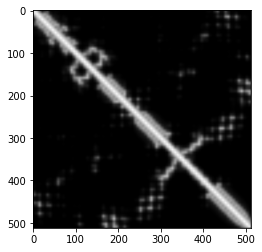

In [383]:
plt.imshow(train_set.load_image(3))

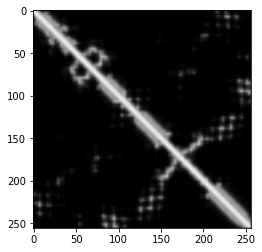

In [38]:
plt.imshow(train_set.load_image(3))

In [11]:
train_set.image_info

[{'id': 0,
  'source': 'dataset',
  'path': '../sword/SWORD/PDBs_Clean/1COBA/file_proba_contact.mat',
  'annot': '../sword/SWORD/PDBs_Clean/1COBA/Peeling/Peeling.log'},
 {'id': 1,
  'source': 'dataset',
  'path': '../sword/SWORD/PDBs_Clean/1STFI/file_proba_contact.mat',
  'annot': '../sword/SWORD/PDBs_Clean/1STFI/Peeling/Peeling.log'},
 {'id': 2,
  'source': 'dataset',
  'path': '../sword/SWORD/PDBs_Clean/3HHRB/file_proba_contact.mat',
  'annot': '../sword/SWORD/PDBs_Clean/3HHRB/Peeling/Peeling.log'},
 {'id': 3,
  'source': 'dataset',
  'path': '../sword/SWORD/PDBs_Clean/451CA/file_proba_contact.mat',
  'annot': '../sword/SWORD/PDBs_Clean/451CA/Peeling/Peeling.log'},
 {'id': 4,
  'source': 'dataset',
  'path': '../sword/SWORD/PDBs_Clean/1LTSA/file_proba_contact.mat',
  'annot': '../sword/SWORD/PDBs_Clean/1LTSA/Peeling/Peeling.log'},
 {'id': 5,
  'source': 'dataset',
  'path': '../sword/SWORD/PDBs_Clean/1AMPA/file_proba_contact.mat',
  'annot': '../sword/SWORD/PDBs_Clean/1AMPA/Peeling/P

In [104]:
test_set.image_info

[{'id': 0,
  'source': 'dataset',
  'path': array(['../../data_peeling/19HCA/full_prob_map.mat'], dtype=object),
  'annot': array(['../../data_peeling/19HCA/Peeling.log'], dtype=object)},
 {'id': 1,
  'source': 'dataset',
  'path': array(['../../data_peeling/1A0AA/full_prob_map.mat'], dtype=object),
  'annot': array(['../../data_peeling/1A0AA/Peeling.log'], dtype=object)},
 {'id': 2,
  'source': 'dataset',
  'path': array(['../../data_peeling/1A0IA/full_prob_map.mat'], dtype=object),
  'annot': array(['../../data_peeling/1A0IA/Peeling.log'], dtype=object)},
 {'id': 3,
  'source': 'dataset',
  'path': array(['../../data_peeling/1A0PA/full_prob_map.mat'], dtype=object),
  'annot': array(['../../data_peeling/1A0PA/Peeling.log'], dtype=object)},
 {'id': 4,
  'source': 'dataset',
  'path': array(['../../data_peeling/1A12A/full_prob_map.mat'], dtype=object),
  'annot': array(['../../data_peeling/1A12A/Peeling.log'], dtype=object)},
 {'id': 5,
  'source': 'dataset',
  'path': array(['../../da

In [316]:
m,_ = train_set.load_mask(2)

In [317]:
train_set.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [29]:
train_set.load_image(2).shape

(256, 256)

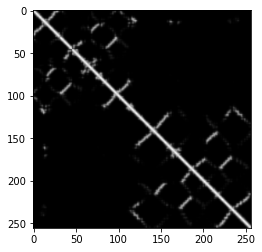

In [319]:
plt.imshow(train_set.load_image(2))


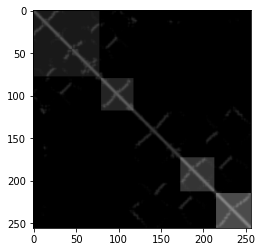

In [318]:
plt.imshow(train_set.load_image(2))
for i in range(4):
    plt.imshow(m[:,:,i], cmap="gray",alpha = 0.3)

In [385]:
config = PUConfig()

In [14]:
model = MaskRCNN(mode='training', model_dir='../results/', config = config )
# load weights (mscoco) and exclude the output layers
model.load_weights('/home/ragou/repo/github/mask/Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=0.001, epochs=5, layers='heads')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.

Starting at epoch 0. LR=0.001

Checkpoint Path: ../results/sword_pu_cfg20211118T1240/mask_rcnn_sword_pu_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/home/ragou/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


KeyboardInterrupt: 

# PREDICTIONS

10 epoch : 

131/131 [==============================] - 93s 713ms/step - batch: 65.0000 - size: 1.0000 - loss: 1.6026 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.5268 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.3700 - mrcnn_mask_loss: 0.3795 - val_loss: 1.7908 - val_rpn_class_loss: 0.1071 - val_rpn_bbox_loss: 0.6950 - val_mrcnn_class_loss: 0.2211 - val_mrcnn_bbox_loss: 0.3794 - val_mrcnn_mask_loss: 0.3883

In [18]:
# detect kangaroos in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset


from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image, unmold_image
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


# Load Model

In [296]:
!chmod 775 ../results/ -R
model = MaskRCNN(mode='inference', model_dir='../results/', config = config )
# load weights (mscoco) and exclude the output layers
# model.load_weights("../results/sword_pu_cfg20211118T1237/mask_rcnn_sword_pu_cfg_0001.h5", by_name=True)
# train weights (output layers or 'heads')
# model.train(train_set, test_set, learning_rate=0.001, epochs=5, layers='heads')

# Load Weights 

In [431]:
!chmod 775 ../results/ -R
model.load_weights("../results/sword_pu_full512_cfg20211118T1654/mask_rcnn_sword_pu_full512_cfg_0002.h5", by_name=True)


Re-starting from epoch 2


pu_cfg20211117T1133 --> pas mal

sword_pu_cfg20211117T2323 --> OK epoch 7

131/131 [==============================] - 90s 684ms/step - batch: 65.0000 - size: 1.0000 - loss: 1.6956 - rpn_class_loss: 0.1498 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.3493 - val_loss: 1.3416 - val_rpn_class_loss: 0.1143 - val_rpn_bbox_loss: 0.3344 - val_mrcnn_class_loss: 0.2010 - val_mrcnn_bbox_loss: 0.3535 - val_mrcnn_mask_loss: 0.3384


In [16]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

5
image ID: dataset.5 (5) ../sword/SWORD/PDBs_Clean/1ALKA/file_proba_contact.mat
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  124.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (12, 4)               min:    1.00000  max:  512.00000  int32
gt_mask                  shape: (56, 56, 12)          min:    1.00000  max:    1.00000  bool


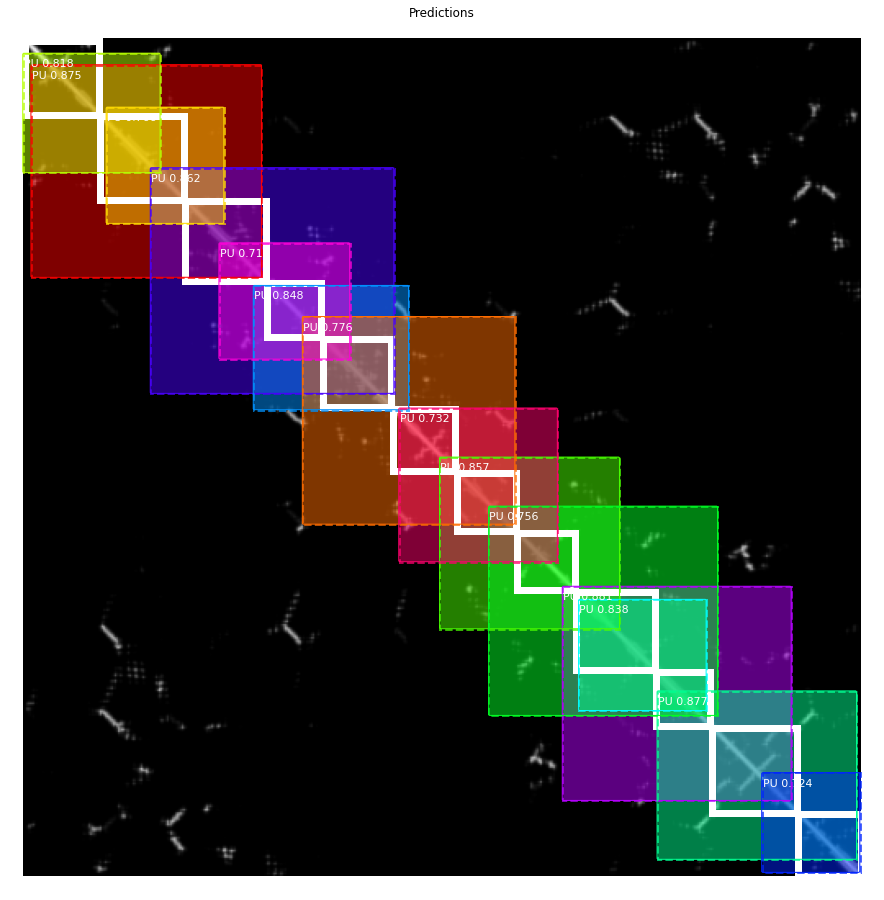

In [434]:
image_id = random.choice(test_set.image_ids)
# image_id = 3

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(test_set, config, image_id)
print(image_id)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

lab = test_set.get_PU(image_id)

for i_box in range(len(lab)):
    # get coordinates
    x1, y1 = lab[i_box]
    # calculate width and height of the box
    size = y1 - x1
    # create the shape
    rect = Rectangle((x1, x1), size, size, fill=False, color='white', lw = 7)
    # draw the box
    ax.add_patch(rect)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
# plt.imshow(image)


In [27]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        print(AP)
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [187]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

ValueError: shapes (8,65536) and (3136,9) not aligned: 65536 (dim 1) != 3136 (dim 0)

In [166]:
!pip3 install scikit-image==0.16.2

     |████████████████████████████████| 26.5 MB 37.4 MB/s eta 0:00:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [186]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, config)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, config)
print("Test mAP: %.3f" % test_mAP)

0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [232]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=1):
    plt.figure(figsize=(20,18))
    # load image and mask
    for i in range(n_images):
    
        # load the image and mask
        image = dataset.load_image(4)
        mask, _ = dataset.load_mask(4)
        lab = dataset.get_PU(4)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect([image], verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title(f'Actual id :{4}')
        ax = pyplot.gca()
        # plot each box
        for i_box in range(len(lab)):
            # get coordinates
            x1, y1 = lab[i_box]
            # calculate width and height of the box
            size = y1 - x1
            # create the shape
            rect = Rectangle((x1, x1), size, size, fill=False, color='green')
            # draw the box
            ax.add_patch(rect)
#         # show the figure
#         pyplot.show()
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        print(np.mean(yhat["scores"]))
        # plot each box
        for i_box in range(len(yhat['rois'])):
            # get coordinates
            y1, x1, y2, x2 = yhat['rois'][i_box]
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            if yhat['scores'][i_box] > 0.71:
                
                rect = Rectangle((x1, y1), width, height, fill=False, color='red')
                # draw the box
                ax.add_patch(rect)
    # show the figure
    pyplot.show()

0.7782372


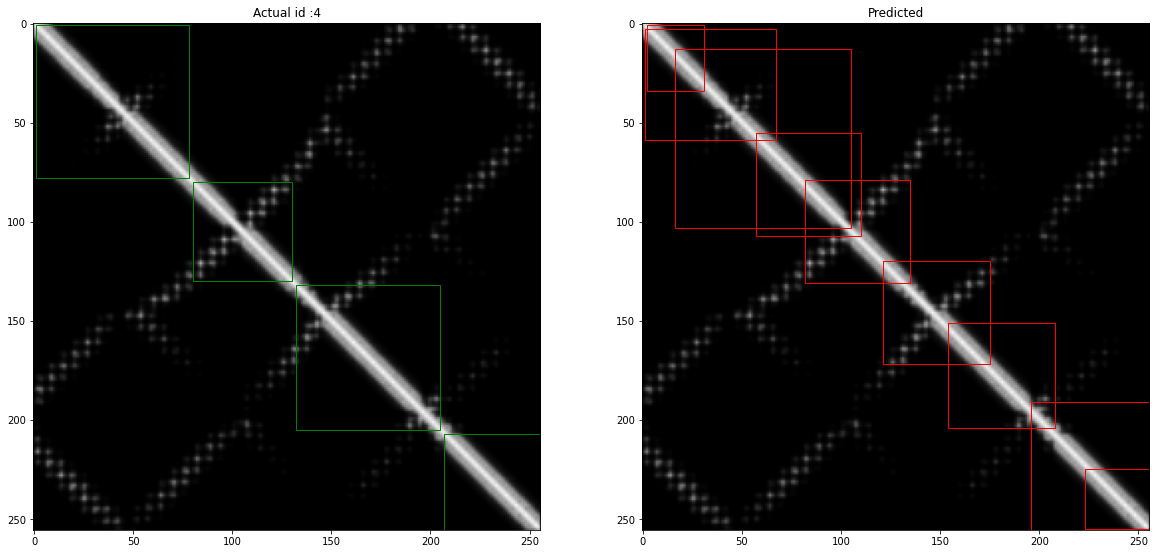

In [233]:
plot_actual_vs_predicted(test_set, model, config)

0.74071574
0.72429043


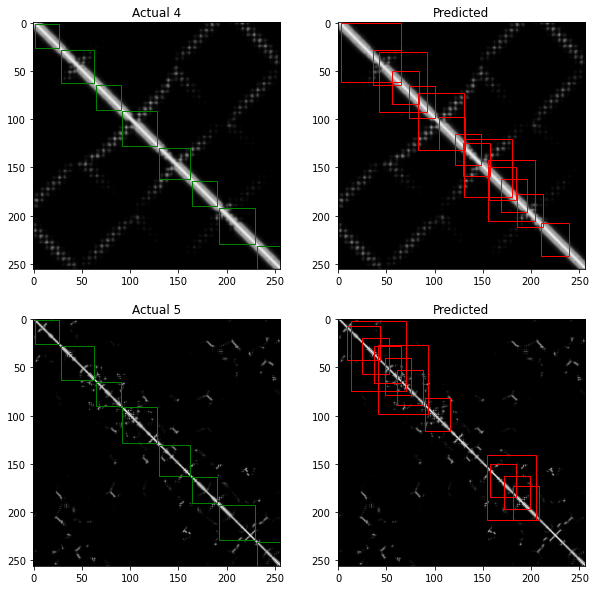

In [432]:
plot_actual_vs_predicted(test_set, model, config)

0.72200626
0.77296704


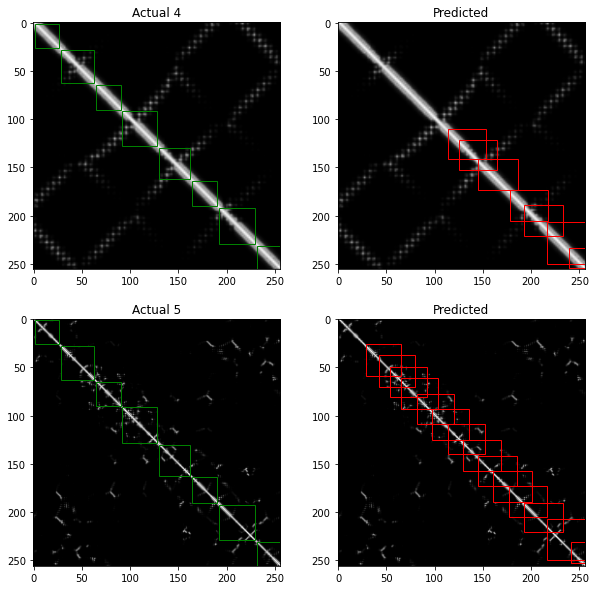

In [358]:
plot_actual_vs_predicted(test_set, model, config)